In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
import numpy as np
from matplotlib import cm

import seaborn as sns
from scipy import stats



#raw = pd.pandas.read_csv('../setup_data/pred_1x1_20181206.csv',sep=",",low_memory=False)
raw = pd.pandas.read_csv('../20181220_raw_geo.csv',sep=",",low_memory=False)

#https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

# Setup Data Set for variable calculation

In [2]:
print(raw.columns)

Index(['published', 'sold_date', 'object_type', 'living_area', 'rooms',
       'floor', 'rent', 'list_price', 'sold_price', 'sold_price_source',
       'construction_year', 'address_street_address',
       'region_municipality_name', 'region_county_name', 'apartment_number',
       'distance_ocean', 'source_name', 'source_type', 'source_id',
       'additional_area', 'location_named_areas', 'plot_area',
       'published_week', 'published_month', 'sold_week', 'sold_month',
       'sqm_list_price', 'sqm_sold_price', 'sqm_rent_price', 'area_from_geo',
       'min_distance_to_metro'],
      dtype='object')


In [3]:
# copy raw data & create new base variables

data = raw.copy()
data['published_dt'] = pd.to_datetime(raw['published'])
data['sold_dt'] = pd.to_datetime(raw['sold_date'])
data['sqm_price_diff'] = data['sqm_sold_price'] - data['sqm_list_price']
data['cnt'] = 1
data = data[data['published'] >'2018-10-01']
print(len(data))

3161


# Variable on key: area_from_geo

In [4]:
import datetime
from datetime import datetime

vars_for_geo_area_df = data.copy()
# only calculate for apts where more than top 20% apts in area
geo_cnt_limit = 0.05*max(vars_for_geo_area_df.groupby('area_from_geo').published.transform(len))
vars_for_geo_area_df = vars_for_geo_area_df[vars_for_geo_area_df.groupby('area_from_geo').published.transform(len) > geo_cnt_limit]

# only calculate for apts where more than top 20% apts for broker
source_name_cnt_limit = 0.05*max(vars_for_geo_area_df.groupby('source_name').published.transform(len))
vars_for_geo_area_df = vars_for_geo_area_df[vars_for_geo_area_df.groupby('source_name').published.transform(len) > source_name_cnt_limit]
print('removing areas with less than ' + str(round(geo_cnt_limit)) + ' apts')
print('removing brokers with less than ' + str(round(source_name_cnt_limit)) + ' apts')

len(vars_for_geo_area_df)


removing areas with less than 21 apts
removing brokers with less than 24 apts


2483

In [5]:
#######################################################################
## Define functions that will be used in lambda functions for a dataset
#######################################################################

# Expanding window mean for a variable
def expanding_mean_for_var(row,var_to_calc,historic_df):
    var = historic_df[
        (historic_df['published_dt'] < row['published_dt'])
    ][var_to_calc].mean()
    return var

# Expanding window mean for a variable in a group
def expanding_mean_for_var_per_group(row,var_to_calc,historic_df,group):
    var = historic_df[
        (historic_df['published_dt'] < row['published_dt'])
        & (historic_df[group] == row[group])
    ][var_to_calc].mean()
    return var

# Rolling window mean for a variable
def rolling_mean_for_var(row,var_to_calc,historic_df,days):
    var = historic_df[
        (historic_df['published_dt'] < row['published_dt'])
        & (historic_df['published_dt'] > (row['published_dt'] - pd.to_timedelta(days, unit='d')))
    ][var_to_calc].mean()
    return var

# Rolling window mean for a variable in a group
def rolling_mean_for_var_per_group(row,var_to_calc,historic_df,group,days):
    var = historic_df[
        (historic_df['published_dt'] < row['published_dt'])
        & (historic_df['published_dt'] > (row['published_dt'] - pd.to_timedelta(days, unit='d')))
        & (historic_df[group] == row[group])
    ][var_to_calc].mean()
    return var



In [11]:
# SQM_SOLD_PRICE
before = datetime.now()
expanding_mean_sqm_price = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df),axis=1)
expanding_mean_sqm_price_per_area = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='area_from_geo'),axis=1)
expanding_mean_sqm_price_per_broker = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='source_name'),axis=1)
rolling_mean_sqm_price_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,days=30),axis=1)
rolling_mean_sqm_price_per_area_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='area_from_geo',days=30),axis=1)
rolling_mean_sqm_price_per_broker_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='source_name',days=30),axis=1)
rolling_mean_sqm_price_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,days=90),axis=1)
rolling_mean_sqm_price_per_area_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='area_from_geo',days=90),axis=1)
rolling_mean_sqm_price_per_broker_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='source_name',days=90),axis=1)
rolling_mean_sqm_price_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,days=180),axis=1)
rolling_mean_sqm_price_per_area_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='area_from_geo',days=180),axis=1)
rolling_mean_sqm_price_per_broker_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_sold_price',historic_df=vars_for_geo_area_df,group='source_name',days=180),axis=1)
after = datetime.now()
print("run time: "+str((after-before).total_seconds()) + " sec")


run time: 48.209437 sec


In [7]:
## SQM_PRICE_DIFF
before = datetime.now()
expanding_mean_sqm_price_diff = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df),axis=1)
expanding_mean_sqm_price_diff_per_area = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var_per_group(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df,group='area_from_geo'),axis=1)
rolling_mean_sqm_price_diff_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df,days=30),axis=1)
rolling_mean_sqm_price_diff_per_area_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df,group='area_from_geo',days=30),axis=1)
rolling_mean_sqm_price_diff_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df,days=90),axis=1)
rolling_mean_sqm_price_diff_per_area_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df,group='area_from_geo',days=90),axis=1)
rolling_mean_sqm_price_diff_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df,days=180),axis=1)
rolling_mean_sqm_price_diff_per_area_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_price_diff',historic_df=vars_for_geo_area_df,group='area_from_geo',days=180),axis=1)
after = datetime.now()
print("run time: "+str((after-before).total_seconds()) + " sec")

run time: 32.21589 sec


In [8]:
## SQM
before = datetime.now()
expanding_mean_sqm = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df),axis=1)
expanding_mean_sqm_per_area = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var_per_group(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df,group='area_from_geo'),axis=1)
rolling_mean_sqm_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df,days=30),axis=1)
rolling_mean_sqm_per_area_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df,group='area_from_geo',days=30),axis=1)
rolling_mean_sqm_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df,days=90),axis=1)
rolling_mean_sqm_per_area_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df,group='area_from_geo',days=90),axis=1)
rolling_mean_sqm_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df,days=180),axis=1)
rolling_mean_sqm_per_area_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='living_area',historic_df=vars_for_geo_area_df,group='area_from_geo',days=180),axis=1)
after = datetime.now()
print("run time: "+str((after-before).total_seconds()) + " sec")

run time: 30.687725 sec


In [9]:
## SQM_RENT_PRICE
before = datetime.now()
expanding_mean_sqm_rent = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df),axis=1)
expanding_mean_sqm_rent_per_area = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var_per_group(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df,group='area_from_geo'),axis=1)
rolling_mean_sqm_rent_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df,days=30),axis=1)
rolling_mean_sqm_rent_per_area_30d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df,group='area_from_geo',days=30),axis=1)
rolling_mean_sqm_rent_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df,days=90),axis=1)
rolling_mean_sqm_rent_per_area_90d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df,group='area_from_geo',days=90),axis=1)
rolling_mean_sqm_rent_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df,days=180),axis=1)
rolling_mean_sqm_rent_per_area_180d = vars_for_geo_area_df.apply(lambda row: rolling_mean_for_var_per_group(row=row,var_to_calc='sqm_rent_price',historic_df=vars_for_geo_area_df,group='area_from_geo',days=180),axis=1)
after = datetime.now()
print("run time: "+str((after-before).total_seconds()) + " sec")


run time: 29.767216 sec


In [13]:
## COMBINED VARS
rolling_mean_sqm_price_area_vs_market_std_30d = (rolling_mean_sqm_price_per_area_30d - rolling_mean_sqm_price_30d)/(rolling_mean_sqm_price_per_area_30d - rolling_mean_sqm_price_30d).std()
rolling_mean_sqm_price_area_vs_market_std_90d = (rolling_mean_sqm_price_per_area_90d - rolling_mean_sqm_price_90d)/(rolling_mean_sqm_price_per_area_90d - rolling_mean_sqm_price_90d).std()
rolling_mean_sqm_price_area_vs_market_std_180d = (rolling_mean_sqm_price_per_area_180d - rolling_mean_sqm_price_180d)/(rolling_mean_sqm_price_per_area_180d - rolling_mean_sqm_price_180d).std()


#tmp_df['mean_sqm_price_expanding_vs_area_diff'] = tmp_df['mean_price_expanding_in_area']-tmp_df['mean_price_expanding']
#tmp_df['mean_sqm_price_expanding_vs_area_std'] = tmp_df['mean_sqm_price_expanding_vs_area_diff']/tmp_df['mean_sqm_price_expanding_vs_area_diff'].std()

In [15]:
## NAME AND MERGE TO DATAFRAME

# SQM_SOLD_PRICE

expanding_mean_sqm_price.name = 'expanding_mean_sqm_price'
expanding_mean_sqm_price_per_area.name = 'expanding_mean_sqm_price_per_area'
expanding_mean_sqm_price_per_broker.name = 'expanding_mean_sqm_price_per_broker'
rolling_mean_sqm_price_30d.name = 'rolling_mean_sqm_price_30d'
rolling_mean_sqm_price_per_area_30d.name = 'rolling_mean_sqm_price_per_area_30d'
rolling_mean_sqm_price_per_broker_30d.name = 'rolling_mean_sqm_price_per_broker_30d'
rolling_mean_sqm_price_90d.name = 'rolling_mean_sqm_price_90d'
rolling_mean_sqm_price_per_area_90d.name = 'rolling_mean_sqm_price_per_area_90d'
rolling_mean_sqm_price_per_broker_90d.name = 'rolling_mean_sqm_price_per_broker_90d'
rolling_mean_sqm_price_180d.name = 'rolling_mean_sqm_price_180d'
rolling_mean_sqm_price_per_area_180d.name = 'rolling_mean_sqm_price_per_area_180d'
rolling_mean_sqm_price_per_broker_180d.name = 'rolling_mean_sqm_price_per_broker_180d'

## SQM_PRICE_DIFF
expanding_mean_sqm_price_diff.name = 'expanding_mean_sqm_price_diff'
expanding_mean_sqm_price_diff_per_area.name = 'expanding_mean_sqm_price_diff_per_area'
rolling_mean_sqm_price_diff_30d.name = 'rolling_mean_sqm_price_diff_30d'
rolling_mean_sqm_price_diff_per_area_30d.name = 'rolling_mean_sqm_price_diff_per_area_30d'
rolling_mean_sqm_price_diff_90d.name = 'rolling_mean_sqm_price_diff_90d'
rolling_mean_sqm_price_diff_per_area_90d.name = 'rolling_mean_sqm_price_diff_per_area_90d'
rolling_mean_sqm_price_diff_180d.name = 'rolling_mean_sqm_price_diff_180d'
rolling_mean_sqm_price_diff_per_area_180d.name = 'rolling_mean_sqm_price_diff_per_area_180d'

## SQM
expanding_mean_sqm.name = 'expanding_mean_sqm'
expanding_mean_sqm_per_area.name = 'expanding_mean_sqm_per_area'
rolling_mean_sqm_30d.name = 'rolling_mean_sqm_30d'
rolling_mean_sqm_per_area_30d.name = 'rolling_mean_sqm_per_area_30d'
rolling_mean_sqm_90d.name = 'rolling_mean_sqm_90d'
rolling_mean_sqm_per_area_90d.name = 'rolling_mean_sqm_per_area_90d'
rolling_mean_sqm_180d.name = 'rolling_mean_sqm_180d'
rolling_mean_sqm_per_area_180d.name = 'rolling_mean_sqm_per_area_180d'

## SQM_RENT_PRICE
expanding_mean_sqm_rent.name = 'expanding_mean_sqm_rent'
expanding_mean_sqm_rent_per_area.name = 'expanding_mean_sqm_rent_per_area'
rolling_mean_sqm_rent_30d.name = 'rolling_mean_sqm_rent_30d'
rolling_mean_sqm_rent_per_area_30d.name = 'rolling_mean_sqm_rent_per_area_30d'
rolling_mean_sqm_rent_90d.name = 'rolling_mean_sqm_rent_90d'
rolling_mean_sqm_rent_per_area_90d.name = 'rolling_mean_sqm_rent_per_area_90d'
rolling_mean_sqm_rent_180d.name = 'rolling_mean_sqm_rent_180d'
rolling_mean_sqm_rent_per_area_180d.name = 'rolling_mean_sqm_rent_per_area_180d'

## COMBINED VARS
rolling_mean_sqm_price_area_vs_market_std_30d.name = 'rolling_mean_sqm_price_area_vs_market_std_30d'
rolling_mean_sqm_price_area_vs_market_std_90d.name = 'rolling_mean_sqm_price_area_vs_market_std_90d'
rolling_mean_sqm_price_area_vs_market_std_180d.name = 'rolling_mean_sqm_price_area_vs_market_std_180d'

new_vars = pd.concat([
    expanding_mean_sqm_price
    ,expanding_mean_sqm_price_per_area
    ,expanding_mean_sqm_price_per_broker
    ,rolling_mean_sqm_price_30d
    ,rolling_mean_sqm_price_per_area_30d
    ,rolling_mean_sqm_price_per_broker_30d
    ,rolling_mean_sqm_price_90d
    ,rolling_mean_sqm_price_per_area_90d
    ,rolling_mean_sqm_price_per_broker_90d
    ,rolling_mean_sqm_price_180d
    ,rolling_mean_sqm_price_per_area_180d
    ,rolling_mean_sqm_price_per_broker_180d
    ,expanding_mean_sqm_price_diff
    ,expanding_mean_sqm_price_diff_per_area
    ,rolling_mean_sqm_price_diff_30d
    ,rolling_mean_sqm_price_diff_per_area_30d
    ,rolling_mean_sqm_price_diff_90d
    ,rolling_mean_sqm_price_diff_per_area_90d
    ,rolling_mean_sqm_price_diff_180d
    ,rolling_mean_sqm_price_diff_per_area_180d
    ,expanding_mean_sqm
    ,expanding_mean_sqm_per_area
    ,rolling_mean_sqm_30d
    ,rolling_mean_sqm_per_area_30d
    ,rolling_mean_sqm_90d
    ,rolling_mean_sqm_per_area_90d
    ,rolling_mean_sqm_180d
    ,rolling_mean_sqm_per_area_180d
    ,expanding_mean_sqm_rent
    ,expanding_mean_sqm_rent_per_area
    ,rolling_mean_sqm_rent_30d
    ,rolling_mean_sqm_rent_per_area_30d
    ,rolling_mean_sqm_rent_90d
    ,rolling_mean_sqm_rent_per_area_90d
    ,rolling_mean_sqm_rent_180d
    ,rolling_mean_sqm_rent_per_area_180d
    # combined
    ,rolling_mean_sqm_price_area_vs_market_std_30d
    ,rolling_mean_sqm_price_area_vs_market_std_90d
    ,rolling_mean_sqm_price_area_vs_market_std_180d
], axis=1)

vars_for_geo_area_df = pd.merge(vars_for_geo_area_df, new_vars,left_index = True, right_index=True, how = 'left')



In [16]:


vars_for_geo_area_df = pd.merge(vars_for_geo_area_df, new_vars,left_index = True, right_index=True, how = 'left')



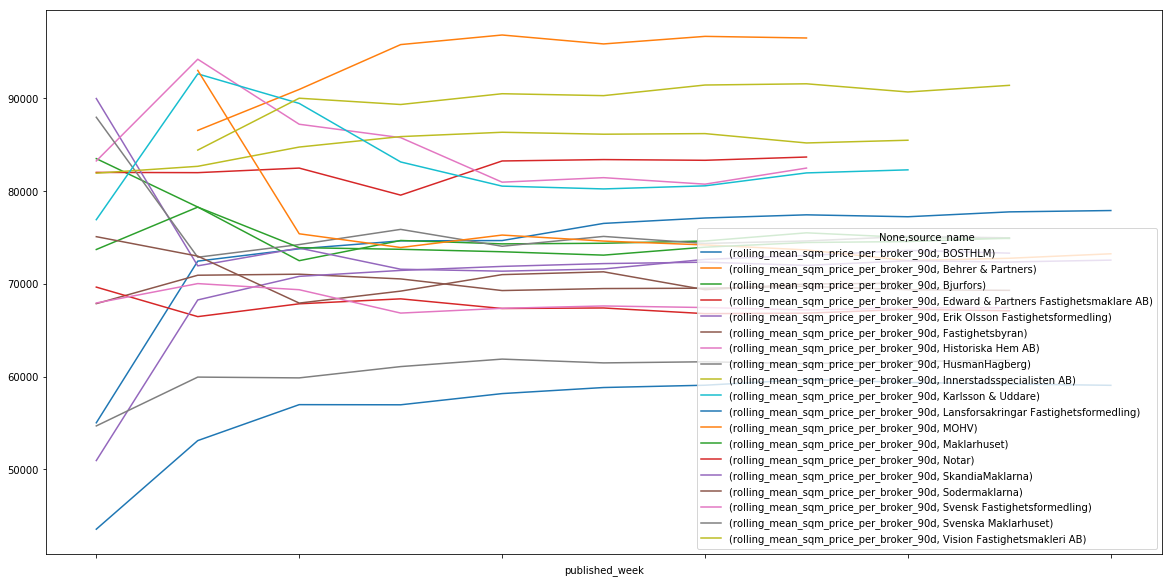

In [30]:
hej = vars_for_geo_area_df[['published_week','source_name','rolling_mean_sqm_price_per_broker_90d']].groupby(['published_week','source_name']).mean()
hej.unstack().plot(figsize=(20,10))



In [ ]:
# calculates expanding window for apts before its publish date
# row: the apt the variable is calculated for
# var_to_calc: the variable that will be sumed or taken mean on
# calculatation: mean or sum
# historic_df: the data used to calculate the variable on
def expanding_mean_for_var(row,var_to_calc,historic_df):
    var = historic_df[
        (historic_df['published_dt'] < row['published_dt'])
    ][var_to_calc].mean()
    return var

before = datetime.now()
# for each ro in vars_for_geo_area_df the function is run
expanding_mean_sqm_price = vars_for_geo_area_df.apply(lambda row: expanding_mean_for_var_in_group(row=row,var_to_calc='sqm_sold_price',group='area_from_geo',historic_df=vars_for_geo_area_df),axis=1)
after = datetime.now()
print("run time: "+str((after-before).total_seconds()) + " sec")

expanding_mean_sqm_price.name = 'expanding_mean_sqm_price'
expanding_mean_sqm_price = pd.DataFrame(expanding_mean_sqm_price)
vars_for_geo_area_df = pd.merge(vars_for_geo_area_df, expanding_mean_sqm_price,left_index = True, right_index=True, how = 'left')


In [ ]:
### TRY TO SOLVE WITH INDEXES
#test = data.copy()
#test = test.set_index(['published_dt','area_from_geo'])
#
#def mean_price_expanding_in_area_index(row,var_to_calc):
#    test.apply(lambda row: test.loc[
#        (test.index.get_level_values('published_dt') < row.name[0])
#        & (test.index.get_level_values('area_from_geo') == row.name[1])
#    ]['sqm_sold_price'].mean(), axis=1)
#
#print(str(datetime.now()))
#mpt = tmp_df.apply(lambda row: mean_price_expanding_in_area_index(row,'sqm_sold_price'),axis=1)
#print(str(datetime.now()))
#

In [ ]:

# for each row in tmp_df (apply) we calculate the mean sold price for all apts (calc time 35sek)

mean_price_expanding.name = 'mean_price_expanding'
mean_price_expanding = pd.DataFrame(mean_price_expanding)
tmp_df = pd.merge(tmp_df, mean_price_expanding,left_index = True, right_index=True, how = 'left')


In [ ]:
tmp_df['mean_sqm_price_expanding_vs_area_diff'] = tmp_df['mean_price_expanding_in_area']-tmp_df['mean_price_expanding']
tmp_df['mean_sqm_price_expanding_vs_area_std'] = tmp_df['mean_sqm_price_expanding_vs_area_diff']/tmp_df['mean_sqm_price_expanding_vs_area_diff'].std()


In [ ]:
data = pd.merge(data, tmp_df[['mean_price_expanding_in_area','mean_price_expanding','mean_sqm_price_expanding_vs_area_diff','mean_sqm_price_expanding_vs_area_std']], left_index = True, right_index=True, how = 'left')





## Visualize the created variable

In [ ]:
print(data.columns)
data['mean_sqm_price_30d_vs_60d_30d'].hist()
plt.show()
data['mean_living_area_60d'].hist()
plt.show()
data['mean_price_expanding'].hist()
plt.show()
data['mean_sqm_price_expanding_vs_area_std'].hist()
plt.show()

#'mean_sqm_sold_price_30d',
#'mean_sqm_sold_price_60d',
#'mean_sqm_sold_price_90d',
#'sum_cnt_30d',
#'sum_cnt_60d',
#'sum_cnt_90d',
#'mean_living_area_30d',
#'mean_living_area_60d',
#'mean_living_area_90d',
#'mean_sqm_price_30d_vs_60d_30d'
    
#sns.distplot(plot_data, kde=False, rug=True);


# Save Output

In [ ]:
output = data.loc[data['published_dt'] >'2016-04-01'][
    ['published_dt'
    ,'sqm_sold_price'
    ,'rooms'
    ,'floor'
    ,'rent'
    ,'construction_year'
    ,'distance_ocean'
    ,'published_week'
    ,'published_month'
    ,'sqm_list_price'
    ,'sqm_rent_price'
    ,'area_from_geo'
    ,'min_distance_to_metro'
    ,'mean_sqm_sold_price_30d'
    ,'mean_sqm_sold_price_60d'
    ,'sum_cnt_30d'
    ,'sum_cnt_60d'
    ,'mean_living_area_30d'
    ,'mean_living_area_60d'
    ,'mean_sqm_price_30d_vs_60d_30d'
    ,'mean_price_expanding_in_area'
    ,'mean_price_expanding'
    ,'mean_sqm_price_expanding_vs_area_diff'
    ,'mean_sqm_price_expanding_vs_area_std'
    ]
]


In [ ]:
output.to_csv('featured_variables.csv',index=False)

In [ ]:

# ## KEY: published_at
# # rolling avarage
# def rolling_avg_for_variable_published(rolling_interval,dataframe,var_to_calc,cal_type):
#     tmp_df = dataframe.copy()
#     tmp_df['published_dt'] = pd.to_datetime(tmp_df['published'])
#     tmp_df = tmp_df.set_index('published_dt')
#     var = tmp_df[[var_to_calc]]
#     if(cal_type == 'mean'):
#         # for each day (D) the mean is calculated for the var and than a rolling mean is calculated
#         var = var.sort_index().resample('D').mean().rolling(rolling_interval).mean()
#     elif(cal_type == 'sum'):
#         # for each day (D) the sum is calculated for the var and than a rolling sum is calculated
#         var = var.sort_index().resample('D').sum().rolling(rolling_interval).sum()
#     var.columns = [cal_type + '_'+var_to_calc +'_' + rolling_interval]
#     return(var)
# 
# ##################################################
# ##################################################
# ##                                              ##
# ##               ROLLING AVG & SUM              ##
# ##                                              ##
# ##################################################
# ##################################################
# 
# #############################
# ## Avarage sold_price rolling
# #############################
# ## calculate rolling mean sold_price
# avg_sqm_sold_price_30d = rolling_avg_for_variable_published('30d',data,'sqm_sold_price','mean')
# avg_sqm_sold_price_60d = rolling_avg_for_variable_published('60d',data,'sqm_sold_price','mean')
# avg_sqm_sold_price_90d = rolling_avg_for_variable_published('90d',data,'sqm_sold_price','mean')
# ## left join the variables (index = published_dt) onto the big dataset using it's column published_dt
# data = pd.merge(data, avg_sqm_sold_price_30d, left_on = 'published_dt', right_index=True, how = 'left')
# data = pd.merge(data, avg_sqm_sold_price_60d, left_on = 'published_dt', right_index=True, how = 'left')
# data = pd.merge(data, avg_sqm_sold_price_90d, left_on = 'published_dt', right_index=True, how = 'left')
# 
# #############################
# ## number of sold rolling
# #############################
# ## calculate rolling mean sold_price
# cnt_30d = rolling_avg_for_variable_published('30d',data,'cnt','sum')
# cnt_60d = rolling_avg_for_variable_published('60d',data,'cnt','sum')
# cnt_90d = rolling_avg_for_variable_published('90d',data,'cnt','sum')
# ## left join the variables (index = published_dt) onto the big dataset using it's column published_dt
# data = pd.merge(data, cnt_30d, left_on = 'published_dt', right_index=True, how = 'left')
# data = pd.merge(data, cnt_60d, left_on = 'published_dt', right_index=True, how = 'left')
# data = pd.merge(data, cnt_90d, left_on = 'published_dt', right_index=True, how = 'left')
# 
# 
# #############################
# ## Avarage sqm size of sold rolling
# #############################
# ## calculate rolling mean sold_price
# avg_sqm_30d = rolling_avg_for_variable_published('30d',data,'living_area','mean')
# avg_sqm_60d = rolling_avg_for_variable_published('60d',data,'living_area','mean')
# avg_sqm_90d = rolling_avg_for_variable_published('90d',data,'living_area','mean')
# ## left join the variables (index = published_dt) onto the big dataset using it's column published_dt
# data = pd.merge(data, avg_sqm_30d, left_on = 'published_dt', right_index=True, how = 'left')
# data = pd.merge(data, avg_sqm_60d, left_on = 'published_dt', right_index=True, how = 'left')
# data = pd.merge(data, avg_sqm_90d, left_on = 'published_dt', right_index=True, how = 'left')
# 
# ##################################################
# ##################################################
# ##                                              ##
# ##        COMPARE TO PREVIOS TIMEPERIOD         ##
# ##                                              ##
# ##################################################
# ##################################################
# 
# 
# ## calculate rolling sum on cnt and sold_price
# cnt_30d = rolling_avg_for_variable_published('30d',data,'cnt','sum')
# cnt_60d = rolling_avg_for_variable_published('60d',data,'cnt','sum')
# sum_sqm_sold_price_30d = rolling_avg_for_variable_published('30d',data,'sqm_sold_price','sum')
# sum_sqm_sold_price_60d = rolling_avg_for_variable_published('60d',data,'sqm_sold_price','sum')
# 
# ## calculate the mean price 30d-60d
# # count 30d - 60d
# cnt_30d_60d = cnt_60d['sum_cnt_60d'] - cnt_30d['sum_cnt_30d']
# # total_sold_price 30d - 60d
# sum_sqm_sold_price_30d_60d = sum_sqm_sold_price_60d['sum_sqm_sold_price_60d'] - sum_sqm_sold_price_30d['sum_sqm_sold_price_30d']
# # avg_sold_price 30d - 60d
# avg_sqm_sold_price_30d_60d = sum_sqm_sold_price_30d_60d/cnt_30d_60d
# ## calculate the diff between last month and this month (60d to 30d vs 30d)
# mean_sqm_price_30d_vs_60d_30d = (avg_sqm_sold_price_30d['mean_sqm_sold_price_30d']-avg_sqm_sold_price_30d_60d)/avg_sqm_sold_price_30d_60d
# mean_sqm_price_30d_vs_60d_30d.name = 'mean_sqm_price_30d_vs_60d_30d'
# mean_sqm_price_30d_vs_60d_30d = pd.DataFrame(mean_sqm_price_30d_vs_60d_30d)
# ## left join the variables (index = published_dt) onto the big dataset using it's column published_dt
# data = pd.merge(data, mean_sqm_price_30d_vs_60d_30d, left_on = 'published_dt', right_index=True, how = 'left')
# print(len(data))
# 